# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL. 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### TODO LIST FOR THE GROUP:

<input type="checkbox" checked > New architecture of file

<input type="checkbox"> Create functions to import and convert initial files

<input type="checkbox"> More comments on the dataset -> distribution, viz

<input type="checkbox"> For any filtering: how, why ?

<input type="checkbox"> Choose a NLP method -> comment as much as possible, some trials 

<input type="checkbox"> E-mail the proposition to Beatriz

## Datasets 📂
### Import dataset and libraries 📥

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from langdetect import detect
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog, smog_index, automated_readability_index, coleman_liau_index, linsear_write_formula, dale_chall_readability_score, text_standard
from utils import *
pd.set_option('display.max_columns', None)

In [2]:
dataset_path = './data/BeerAdvocate/'

In [3]:
#ratings_2 = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='trial_ratings')
#can take a while to run

In [4]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [5]:
# Files already converted, so we can load them directly

#ratings = pd.read_csv(dataset_path + 'ratings.csv')
reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### Initial datasets analysis 🔎

#### Beers dataset 🍺

In [6]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
117147,143231,Hop Lab - Amarillo Hops,26676,Kane Brewing Company,American Pale Ale (APA),6,0,3.83,NaN,NaN,5.40,3.835000,NaN,0,NaN
246152,167066,Cat Fight IPA,40007,Bitter Sisters Brewing Company,American IPA,23,3,3.66,83.0,NaN,6.66,3.695217,-0.557574,4,3.9475
171737,287867,Cameron's British Pub Ale,37452,Pleasure House Brewing,Extra Special / Strong Bitter (ESB),2,1,3.92,NaN,NaN,6.20,4.045000,NaN,0,NaN


Shape of beers :  (280823, 15)


In [7]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score reprensents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

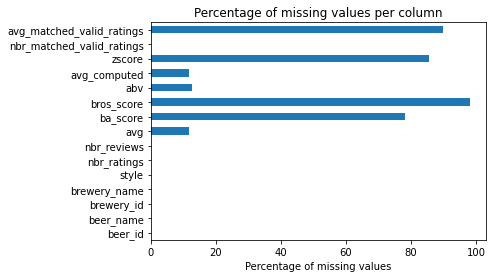

In [8]:
# show the percentage of missing values per columm
plt.figure()
(beers.isna().sum() / len(beers) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. We can drop this column alongside avg_computed and compute them manually later if needed.

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

</blockquote>

In [9]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [10]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
252666,88990,24445,Saison / Farmhouse Ale,10,3,3.97,6.0
166941,267904,43575,American Malt Liquor,0,0,NaN,4.5
190230,164332,11599,Berliner Weissbier,14,1,4.07,4.3


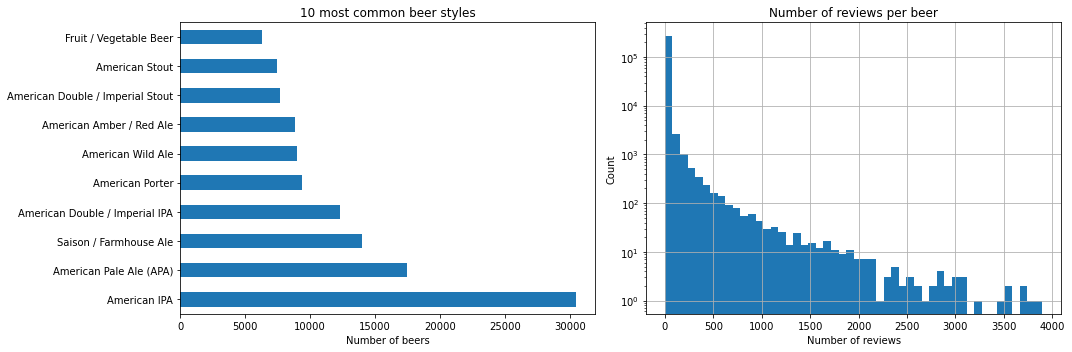

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

In [12]:
# Some beers have no reviews and no ratings, resulting in NaN avg value, we remove them
beers_filtered = beers_filtered[beers_filtered['avg'].notna()].copy(deep=True)

# We also remove the few beers that have 0 reviews and 0 ratings but a non NaN avg value (not sure why there are such beers)
beers_filtered = beers_filtered[(beers_filtered['beer_nbr_reviews'] != 0) & (beers_filtered['beer_nbr_ratings'] != 0)].copy(deep=True)

In [13]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,166649.000000,166649.000000,166649.000000,166649.000000,166649.000000,144879.000000
mean,118304.063271,17174.929871,49.216653,15.539163,3.709953,6.566462
std,82294.748008,14573.636775,298.336124,88.846266,0.489242,2.138165
min,3.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,50831.000000,1853.000000,2.000000,1.000000,3.500000,5.000000
50%,95991.000000,16111.000000,5.000000,2.000000,3.780000,6.000000
75%,184603.000000,30176.000000,17.000000,5.000000,4.020000,7.600000
max,293285.000000,49815.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a clean dataset containing 166'649 beers. Some beers do not have a alcohol percentage value.

</blockquote>

#### Breweries dataset 🏭

In [14]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
7830,35495,Ireland,Four Provinces Brewing Company,2
11734,27942,"United States, Minnesota",Boom Island Brewing Company,31
8512,140,"United States, California",Sierra Nevada Brewing Co.,574


Shape of breweries :  (16758, 4)


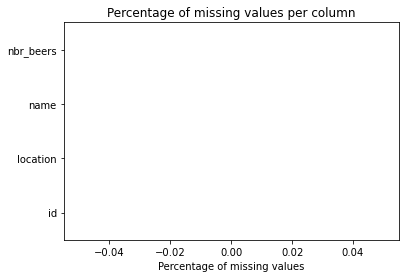

In [15]:
# show the percentage of missing values per columm
plt.figure()
(breweries.isna().sum() / len(breweries) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [16]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)
breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [17]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,brewery_nbr_beers
12589,4552,"United States, Florida",17
10492,33770,"United States, Arizona",15
14314,39945,North Korea,1


In [18]:
# Some breweries have weird location values, should find a way to clean them or simply remove them

print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# remove the breweries with a weird location value
breweries_filtered = breweries_filtered[~breweries_filtered['brewery_location'].str.contains('<', na=False)].copy(deep=True)

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique()[0:5]:
#     print(loc) # print the first 5 strange values

Number of breweries with a weird location value: 35


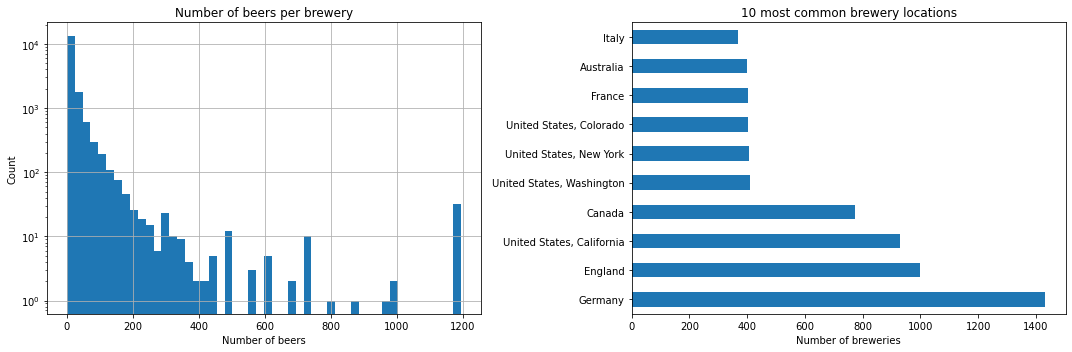

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### Users dataset 👤

In [20]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
142453,1,0,stestand84.1011187,Stestand84,1.436350e+09,"United States, Michigan"
132444,1,0,jaimenk4.862038,Jaimenk4,1.410516e+09,NaN
2863,474,468,seand.289492,seand,1.232363e+09,"United States, California"


Shape of users :  (153704, 6)


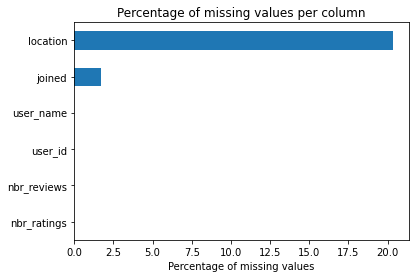

In [21]:
plt.figure()
(users.isna().sum() / len(users) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [22]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
43075,104,0,ajpowell5.770072,1.387278e+09,"United States, New Jersey"
36764,7,0,jwnyc.729006,1.366193e+09,"United States, New Jersey"
39405,6,0,maxhoel.824224,1.405159e+09,NaN


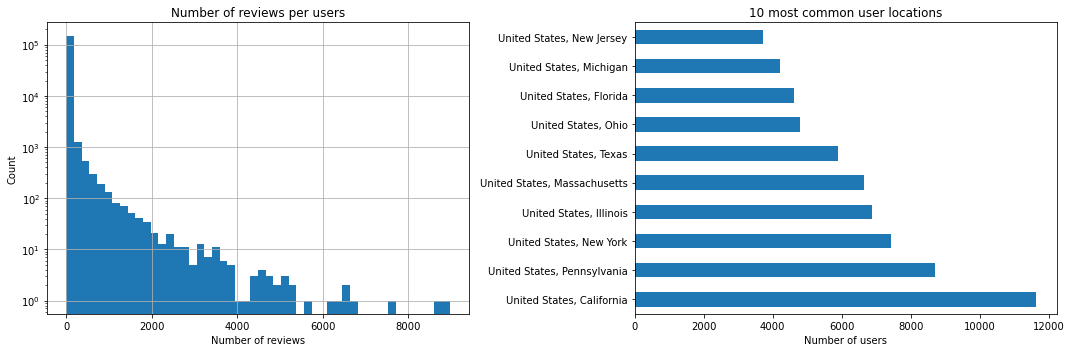

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### Reviews dataset 📝

In [24]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
2245177,Artista Zynergia: Morpheus & Phantasus,233837,OEC Brewing (Ordinem Ecentrici Coctores),34667,Gueuze,6.3,1467021600,TrilliumFan,trilliumfan.902094,4.5,4.25,4.5,4.5,4.5,4.44,"On draft at pizzeria paradiso, poured into a t..."
901643,Black Orchard,42587,The Bruery,16866,Belgian Dark Ale,5.7,1282903200,unclejimbay,unclejimbay.244896,3.5,4.00,4.5,4.5,4.5,4.32,"Bruery Review, we performed a comprehensive sa..."
1071172,UFO Raspberry Hefeweizen,28672,Harpoon Brewery & Beer Hall,98,Fruit / Vegetable Beer,4.8,1220436000,mtstatebeer,mtstatebeer.212042,3.0,3.00,2.5,2.5,3.0,2.75,12 oz. bottle. Pours a orangeish-red color wit...


Shape of reviews :  (2589586, 16)


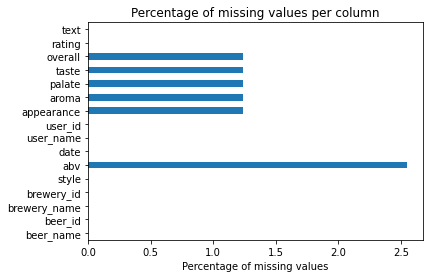

In [25]:
plt.figure()
(reviews.isna().sum() / len(reviews) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [26]:
# making sure that all the NaN are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009
False    2557577
True       32009
Name: all_missing, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can then drop them.

</blockquote>

In [27]:
# remove the columns that are not useful for our analysis

reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text
576110,57912,220,Belgian IPA,8.8,1286618400,lovindahops.442008,4.0,4.0,4.0,4.0,4.0,4.00,A- complete golden body with a master head of ...
813367,3158,610,American IPA,8.0,1289818800,anaz.407226,4.0,3.5,4.0,4.5,3.5,3.98,"A- Dark red brown, with a full creamy head tha..."
1171029,906,99,Black & Tan,5.4,1284804000,drabmuh.4791,4.0,3.5,3.5,3.0,3.5,3.33,Poured into a shaker pint. Beer is black to br...


Shape of reviews_filtered :  (2557577, 13)


In [28]:
# count the number of NaN in columns ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews_filtered[reviews_filtered[col].isna()]))


Number of NaN values for each column :
overall : 0
taste : 0
palate : 0
aroma : 0
appearance : 0


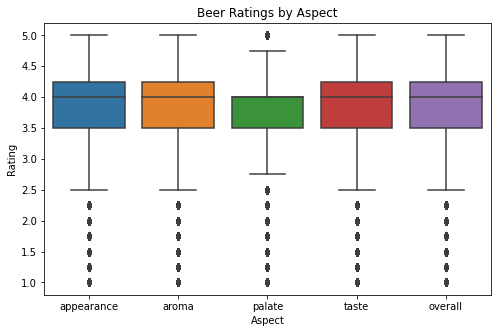

In [29]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### Merge datasets 🔗

In [30]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style', 'abv'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
126222,14732,22,Belgian Strong Pale Ale,10.5,1156327200,phisig137.27541,3.0,4.0,3.5,4.0,4.5,3.99,Cork pops out of this 2 3/4 year old bottle wi...,267,245,4.08,465,465,1.120471e+09,"United States, Virginia",Canada,58.0


Shape of df_merged :  (2557577, 22)


### Filter datasets ✂️

<div class="alert alert-block alert-danger">
<b>Danger:</b> Comment EVERY filtering
</div>

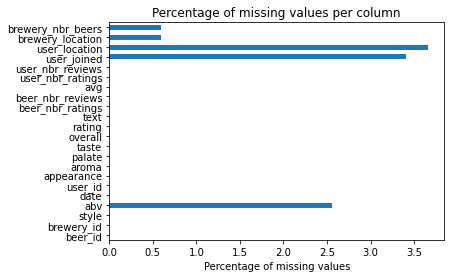

In [31]:
# show the percentage of missing values per columm
plt.figure()
(df_merged.isna().sum() / len(df_merged) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [32]:
df_nonan = df_merged.dropna().copy(deep=True)
print('Shape of df_nonan : ', df_nonan.shape)
print('Percentage of rows removed : ', round((1 - len(df_nonan) / len(df_merged)) * 100, 2), '%')

Shape of df_nonan :  (2387578, 22)
Percentage of rows removed :  6.65 %


In [33]:
# Save to csv
df_nonan.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

In [34]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [35]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
1564634,2093,64,American Double / Imperial IPA,9.0,1176717600,mobud.2158,3.5,4.0,4.0,3.5,4.0,3.77,Poured from bottle into pint glass.A- Dark gol...,15548,3899,4.24,132,129,1.054116e+09,"United States, Delaware","United States, Delaware",378.0
2291306,46850,15237,Belgian Strong Pale Ale,10.0,1294657200,corby112.268461,4.0,3.5,4.0,4.0,3.5,3.78,"Pours a deep, dark copper orange with golden b...",191,100,4.15,2855,2853,1.227092e+09,"United States, Pennsylvania",Belgium,145.0
1417428,38870,694,American Barleywine,9.4,1262948400,wisrarebeer.239007,4.0,4.5,4.5,4.5,5.0,4.57,"A: deep copper color, decent headS: smell was ...",75,68,4.24,1302,682,1.217498e+09,"United States, Wisconsin","United States, Pennsylvania",372.0


Shape of df :  (2387578, 22)


## Data enrichment 🍺
### Serving type 🍾🥤🚰

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served. 
For now, we use a naive approach. We only look at whether a word specific to as service style has been used. 


In [36]:
# Create 3 different columns according to the text review, "bottle", "can", "draft"

bottle = ['bottle', 'bottled', 'bottles']
can = [' can ', 'canned', ' cans ']
draft = ['draft', 'draught', 'tap', 'taps']
# Create different columns if review text contains the word
df['bottle'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in bottle))
df['can'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in can))
df['draft'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in draft))

In [37]:
# remove every row where columns bottle, can and draft are all False
df = df[df[['bottle', 'can', 'draft']].any(axis=1)]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

# remove every row with more than 1 true
df = df[df[['bottle', 'can', 'draft']].sum(axis=1) == 1]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

#create a new column with the serving type
df['serving_type'] = df[['bottle', 'can', 'draft']].idxmax(axis=1)

# drop the columns bottle, can and draft
df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)

display(df.sample(3))

# print the number of reviews for each serving type
df['serving_type'].value_counts(normalize=False)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type
226674,55580,13307,American IPA,6.9,1272016800,john_m.3421,4.0,4.5,4.0,4.5,4.0,4.32,On tap at Max's today.This and the simcoe from...,157,89,4.03,3119,3053,1.067076e+09,"United States, Oregon",Denmark,795.0,draft
1424961,15881,694,American Amber / Red Ale,7.5,1235041200,rdub.157496,4.0,4.0,4.0,4.0,4.0,4.00,Holy moley. Hop-o-rama. Poured a beautiful cop...,8553,2550,4.32,365,156,1.189246e+09,"United States, Pennsylvania","United States, Pennsylvania",372.0,draft
1756646,47022,17981,American Double / Imperial Stout,11.0,1337335200,skibum22.383232,4.5,4.5,5.0,5.0,5.0,4.85,A - Pours black with a finger of dark tan head...,4144,803,4.51,1535,86,1.255860e+09,"United States, New York","United States, Florida",981.0,bottle


bottle    619246
can       187137
draft     165750
Name: serving_type, dtype: int64

## Data filtering 🧹
Number of valid reviews per beer and users & average rating per beer

### Filtering on amount of reviews

In [38]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

df.sample(3)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed
935606,37860,35,American Pale Ale (APA),6.0,1367920800,jadjunk.401113,3.75,3.25,2.75,3.25,3.25,3.23,&quot;Jack McAuliffe's pioneering spirit paved...,625,178,3.40,1175,1175,1.260097e+09,"United States, Georgia","United States, Massachusetts",285.0,bottle,347,65,3.328308
1145616,65223,2137,Milk / Sweet Stout,7.2,1366452000,stouthunter.445745,4.00,3.75,3.50,3.75,3.75,3.74,I picked up a bottle of Breckenridge's 72 Impe...,756,158,3.87,2309,1946,1.270548e+09,"United States, Michigan","United States, Colorado",140.0,bottle,1329,62,3.870484
1570004,18862,64,American Double / Imperial IPA,10.0,1314698400,cavery.553824,3.50,4.00,3.00,3.50,3.50,3.57,"Review from notes, bottle courtesy of GoGators...",6565,1872,4.18,217,207,1.295176e+09,"United States, California","United States, Delaware",378.0,bottle,103,860,4.148012


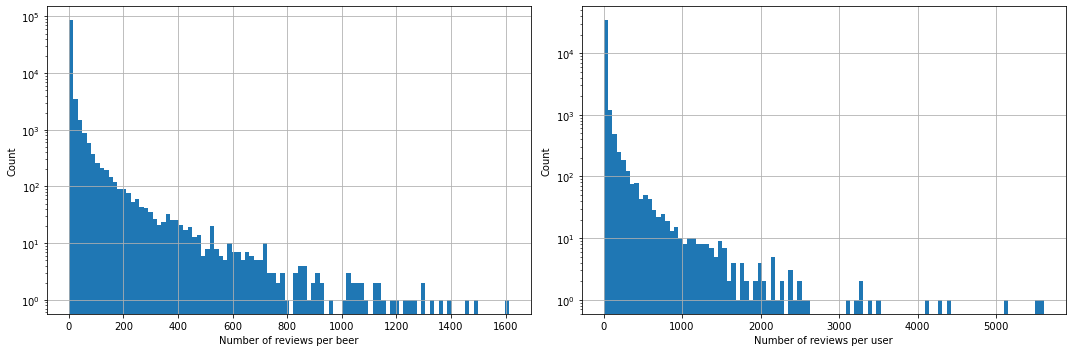

In [39]:
plt.figure(figsize=(15, 5))

# group the reviews by beer_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 1)
df.groupby('beer_id')['beer_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per beer')
plt.ylabel('Count')

# group the reviews by user_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 2)
df.groupby('user_id')['user_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [40]:
#Filtering to remove users and beers with less reviews

min_nbr_reviews_per_user = 0
min_nbr_reviews_per_beer = 20

len0 = df.shape[0]

# remove every row where the number of reviews per user is less than min_nbr_reviews_per_user
df_filter = df[df['user_nbr_reviews_computed'] >= min_nbr_reviews_per_user].copy(deep=True)

# remove every row where the number of reviews per beer is less than min_nbr_reviews_per_beer
df_filter_full = df_filter[df_filter['beer_nbr_reviews_computed'] >= min_nbr_reviews_per_beer].copy(deep=True)

print('We removed {} rows, leaving us with {} %% of the original dataset'.format(len0 - df_filter_full.shape[0], round(df_filter_full.shape[0] / len0 * 100, 2)))
print('We have {} valid reviews'.format(df_filter_full.shape[0]))

# print the number of reviews for each serving type
df_filter_full['serving_type'].value_counts(normalize=False)

We removed 255775 rows, leaving us with 73.69 %% of the original dataset
We have 716358 valid reviews


bottle    489917
can       140341
draft      86100
Name: serving_type, dtype: int64

### Filter on readability score of the reviews 📝

In [41]:
df_sample = df_filter_full.sample(n=1000, random_state=46)

<AxesSubplot:>

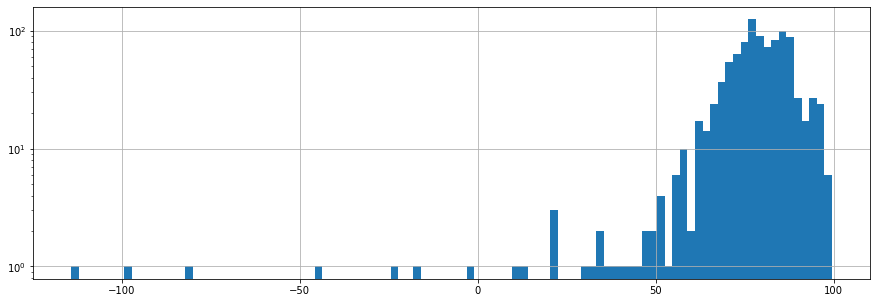

In [42]:
df_sample['readability_score'] = df_sample['text'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else None)
df_sample['readability_score'].hist(bins=100, figsize=(15, 5), log=True)

In [43]:
# printing some reviews based on readability score

df_sample[df_sample['readability_score'] < 20]['text'].count()

# for row in df_sample[df_sample['readability_score'] > 96]['text']:
#     print(row)
#     print('----------------------')

9

In [44]:
# remove reviews with bad readability score



### Extracting the serving mode with NLP

In [45]:
import nltk
import spacy

In [46]:
df_test_nlp = df_sample.copy(deep=True)
nlp = spacy.load("en_core_web_sm")

In [47]:
def extract_serving_style(text):
    # Process the text using spaCy
    doc = nlp(text)
    
    # Initialize the serving style variable
    serving_style = None
    
    # Analyze the dependency tree and part-of-speech tags
    # Find the serving styles
    for token in doc:
        if "can" == token.lemma and token.dep_ == "nsubj":
            serving_style = "can"
            break
        elif "bottle" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "bottle"
            break
        elif "tap" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "tap"
            break
    
    return serving_style

In [48]:
ex_review = str("Can. I would love to try it on tap")

In [49]:
doc = nlp(ex_review)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

Can can AUX ROOT
. . PUNCT punct
I I PRON nsubj
would would AUX aux
love love VERB ROOT
to to PART aux
try try VERB xcomp
it it PRON dobj
on on ADP prep
tap tap NOUN pobj


In [50]:
print(extract_serving_style(ex_review))

None


In [51]:
df_test_nlp['text'].sample(1)

50798    Reviewed 6/21/2006 (16.9 oz bottle):Pours a bl...
Name: text, dtype: object

In [52]:
%%time
df_test_nlp['serving_style'] = df_test_nlp['text'].apply(extract_serving_style)

CPU times: user 25.7 s, sys: 2.23 s, total: 27.9 s
Wall time: 32.5 s


In [63]:
# Look if all serving_style values are still None (True or False)
df_test_nlp['serving_style'].isna().all()

True

In [ ]:
#General fonction that will say if the word "can" is a verb or a noun  
import spacy
nlp = spacy.load("en_core_web_sm")

def differentiate_can(sentence):
    doc = nlp(sentence)
    verbes_nom=[]
    for token in doc:
        if token.text.lower() == "can":
            if any(t.dep_ == "aux" for t in token.head.children):
                verbes_nom .append("verb")
            else:
                verbes_nom .append("noun") 
    
    return verbes_nom

ex_review = str("Can I go to the bathroom I had a beer in a can even if I would have prefered it served by draft because I can")
test = str("Plase can you stop eating from the can")
print(differentiate_can(ex_review))
print(differentiate_can(test))

### Countries grouping 🌍

In [54]:
countries = pd.read_csv('data/countries.csv', usecols=['name', 'region', 'sub-region'])
countries.sample(1)

,name,region,sub-region
100,Hong Kong,Asia,Eastern Asia


### Visualization 📊

In [55]:
# print some reviews for each serving type
print('Reviews with bottle:\n')
for text in df[df['serving_type'] == 'bottle']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with can:\n')
for text in df[df['serving_type'] == 'can']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with draft:\n')
for text in df[df['serving_type'] == 'draft']['text'].sample(1):
    print(text)
    print('----------------------')

Reviews with bottle:

500ml bottle poured into a pint glass.A - Poured a deep gold with a slight haze. Minimal head but a lasting thin layer of bubbles. Minimal lacing.S - Various herbal notes with some grass &amp; flowers. Smells quite pleasing.T - Sweet at first followed by the bitterness with tobacco notes.M - Watery at first but goes down smooth. Also feels a bit sticky.D - It's pretty drinkable but nothing spectacular.
----------------------
Reviews with can:

World Wide Stout is a pleasure to the senses. It pours like a coca-cola, dark, but not in the least bit transparent. The thin dark brown head rounds out an inviting appearance. The aroma is a bit more than I expected. Strong and sharp, its as if you held the roasted malts right up in your nose. Definitely a bit more aromatic than most stouts I have encountered. Strong on the palate, coffee notes abound, the slightly chalky feel compliments the overall smoothness of this brew. I can taste the fine roasted malts as I drink it,

In [56]:
# print the average value of the rating for each serving type
comp_str = 'rating'
print('Average ' + comp_str + ' for bottle: ', round(df[df['serving_type'] == 'bottle'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for can: ', round(df[df['serving_type'] == 'can'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for draft: ', round(df[df['serving_type'] == 'draft'][comp_str].mean(), 3))

Average rating for bottle:  3.832
Average rating for can:  3.816
Average rating for draft:  3.865


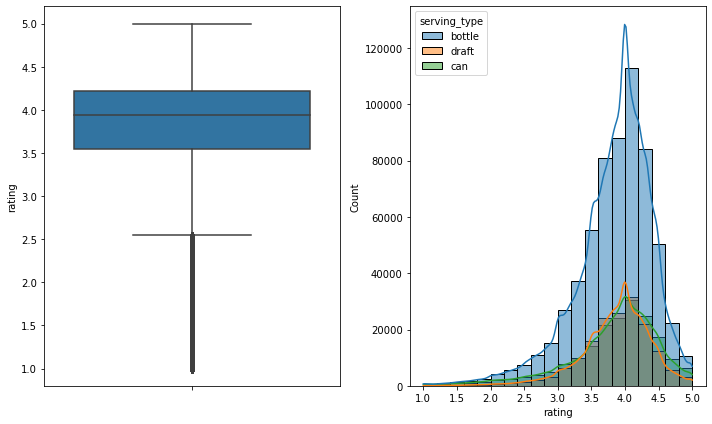

In [57]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type', y='rating')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

# Statistical Analysis 📈

### Measure the impact of each aspect on rating 📏

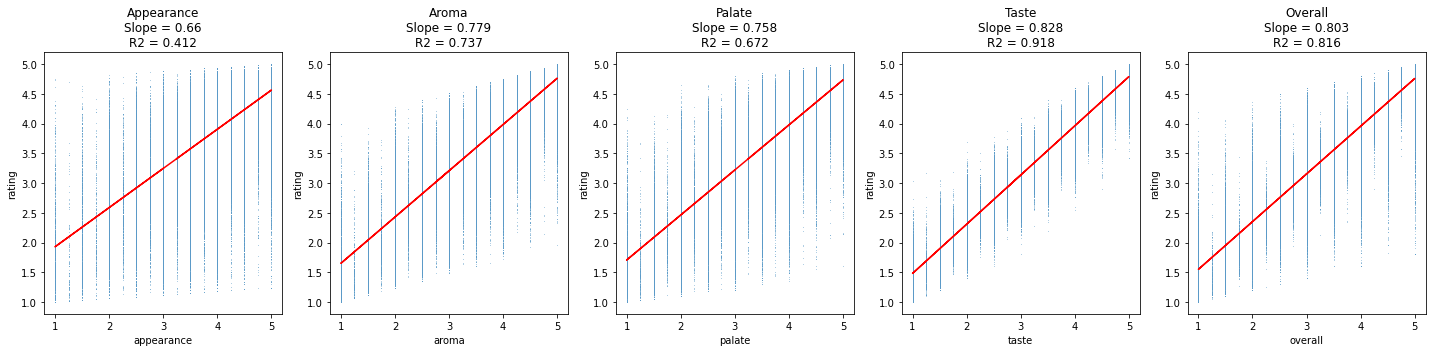

In [58]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### Hypothesis testing on the new labels

In [59]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type'] == type1][category],df[df['serving_type'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

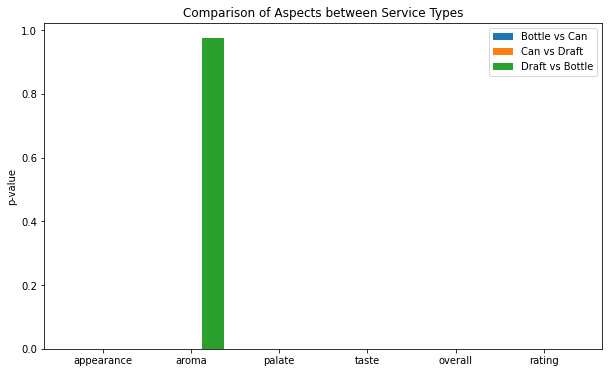

In [60]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type'] == 'bottle'][columns[i]], df[df['serving_type'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type'] == 'can'][columns[i]], df[df['serving_type'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type'] == 'draft'][columns[i]], df[df['serving_type'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
# ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

All the p-values are below 0.05 (expect 1), so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

In [61]:
# t-test for aroma betwwen draft and bottle
do_ttest('draft', 'bottle', 'aroma')

The p-value is high (0.9744195668254092), so we cannot reject the null hypothesis that the two samples have the same average


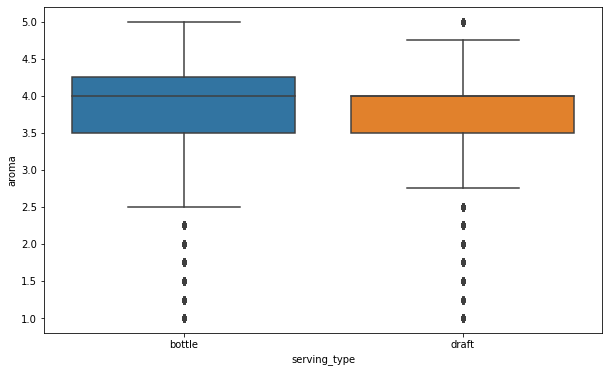

In [62]:
# show a boxplot of aroma for draft and bottle
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['serving_type'].isin(['draft', 'bottle'])], x='serving_type', y='aroma')
plt.show()